# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "0dtheZNlcjBemGJ6PLcIcM8eb"
CONSUMER_SECRET = "7icIh2jU7bwuDzmHr978wB2f3DpK2EEsioAypWKyRuiYGABdvg"

ACCESS_TOKEN_KEY = "781465906413273088-VeNI7oePGsLep2duwLpVOVkIaLTzS3L"
ACCESS_TOKEN_SECRET = "MEVsCOFnnOP6GMVeyfFfdci8cOFZx9n7efypAi87YFe9o"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    try:
        a = api.GetUserTimeline(user_id=user_id)
    except:
        return []
    # your code here
    a = map(lambda x: x.AsDict(), a)
    a = filter(lambda x: x["lang"] == "en", a)
    '''
    return [{'lang': u'en', 
             'favorited': False, 
             'truncated': False, 
             'text': u"So now I'm on the floor tweeting about it PROB w a black eye n swollen nose", 
             'created_at': u'Mon Apr 06 05:59:50 +0000 2015', 
             'retweeted': False, 
             'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 
             'user': {'id': 984121344}, 
             'id': 584958674528964608}]
    '''
    return a

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [3]:
def get_words(text):
    """returns list of words"""
    # your code here
    text = text.lower()
    text = filter(lambda x: (x <= "z" and x >= "a") or x == " ", text).split(" ")
    text = filter(lambda x: len(x) > 0,  text)
    return text

In [4]:
print get_words("Here are different words!")

['here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [5]:
import nltk

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [6]:
import nltk
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

def get_tokens(words):
    w = WordNetLemmatizer()
    ans =  map(lambda x: w.lemmatize(x), words)
    ans = filter(lambda x: not x in stopwords.words("english"), ans)
    return ans

In [7]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [8]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))
    #return ['different', u'word']

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [9]:
from sklearn.feature_extraction import DictVectorizer

In [13]:
def collect_users_tokens(df_users):
    df = df_users
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    uid = df["uid"]
    print len(uid)
    tw = []
    k = 0
    for i in uid:
        if k % 100 == 0:
            print k, k * 1.0 / len(uid),
        k += 1
        tw.append({})
        sen = []
        try:
            sen = map(lambda x: x["text"], get_user_tweets(i))
        except:
            print "except"
        sen = ' '.join(sen)
        tokens = get_tweet_tokens(sen)
        for j in tokens:
            if not j in tw[-1]:
                tw[-1][j] = 0
            tw[-1][j] += 1
    
    np.save("tweets.npy", tw)
    # your code here
    # save intermediate result
    return uid, tw
    #return [12345], [{u'eye': 1, u'floor': 1, u'tweeting': 1, u'n': 1, u'black': 1, u'nose': 1, u'w': 1, u'swollen': 1, u"i'm": 1, u'prob': 1}]


In [14]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer
import numpy as np

#TRAINING_SET_URL = "twitter_train.txt"
#EXAMPLE_SET_URL = "twitter_example.txt"
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"

df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])

df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)


11947
0 0.0 100 0.00837030216791 200 0.0167406043358 300 0.0251109065037 400 0.0334812086716 500 0.0418515108395 600 0.0502218130074 700 0.0585921151754 800 0.0669624173433 900 0.0753327195112 1000 0.0837030216791 1100 0.092073323847 1200 0.100443626015 1300 0.108813928183 1400 0.117184230351 1500 0.125554532519 1600 0.133924834687 1700 0.142295136854 1800 0.150665439022 1900 0.15903574119 2000 0.167406043358 2100 0.175776345526 2200 0.184146647694 2300 0.192516949862 2400 0.20088725203 2500 0.209257554198 2600 0.217627856366 2700 0.225998158534 2800 0.234368460701 2900 0.242738762869 3000 0.251109065037 3100 0.259479367205 3200 0.267849669373 3300 0.276219971541 3400 0.284590273709 3500 0.292960575877 3600 0.301330878045 3700 0.309701180213 3800 0.318071482381 3900 0.326441784548 4000 0.334812086716 4100 0.343182388884 4200 0.351552691052 4300 0.35992299322 4400 0.368293295388 4500 0.376663597556 4600 0.385033899724 4700 0.393404201892 4800 0.40177450406 4900 0.410144806228 5000 0.418

In [16]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [135]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from os import path
from scipy.misc import imread

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    #print vs[2]
    tok = v.get_feature_names()
    num = vs.sum(axis=0)
    num = np.array(num)[0]
    a = list(np.array(sorted(num, reverse=True)).astype(int)[0:100])
    b = list(num)
    c = []
    for i in range(100):
        c.append(tok[b.index(a[i])])
    
    #d = path.dirname(__file__)
    #mask = imread(path.join(d, "tw.png"))
    mask = imread("tw.png")
    wc = WordCloud(background_color="white", max_words=100, mask=mask)
    wc.generate(' '.join(c))
    wc.to_file("tw_new.png")
    
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
    return

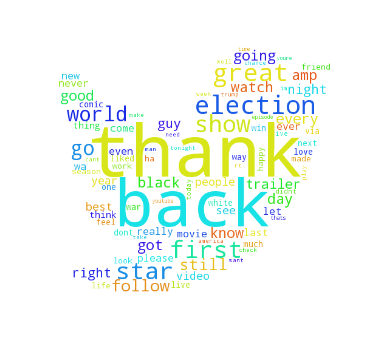

In [133]:
draw_tag_cloud(v, vs)